In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError
from yellowbrick.regressor import prediction_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, mutual_info_regression

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
base_path = '/kaggle/input/self-reported-qol/20230625-processed-'

df_physical      = pd.read_csv(base_path + 'physical-qol.csv')
df_psychological = pd.read_csv(base_path + 'psychological-qol.csv')

df_physical.drop('id', axis=1, inplace=True)         # id
df_physical.drop('day', axis=1, inplace=True)        # day
df_psychological.drop('id', axis=1, inplace=True)    # id
df_psychological.drop('day', axis=1, inplace=True)   # day

phy_all_tmp = df_physical.copy()
phy_init_set_tmp = phy_all_tmp.query("group in ('Initial Set')").copy()
phy_ufpi_ufc_tmp = phy_all_tmp.query("group in ('UFPI', 'UFC')").copy()

psy_all_tmp = df_psychological.copy()
psy_init_set_tmp = psy_all_tmp.query("group in ('Initial Set')").copy()
psy_ufpi_ufc_tmp = psy_all_tmp.query("group in ('UFPI', 'UFC')").copy()

phy_all_tmp.drop("group", axis=1, inplace=True)
phy_init_set_tmp.drop("group", axis=1, inplace=True)
phy_ufpi_ufc_tmp.drop("group", axis=1, inplace=True)

psy_all_tmp.drop("group", axis=1, inplace=True)
psy_init_set_tmp.drop("group", axis=1, inplace=True)
psy_ufpi_ufc_tmp.drop("group", axis=1, inplace=True)

# Separating predictors from the values to be predicted.
phy_all           = phy_all_tmp.drop("phy_ref_score", axis=1)
phy_all_pred      = phy_all_tmp["phy_ref_score"].copy()
phy_init_set      = phy_init_set_tmp.drop("phy_ref_score", axis=1)
phy_init_set_pred = phy_init_set_tmp["phy_ref_score"].copy()
phy_ufpi_ufc      = phy_ufpi_ufc_tmp.drop("phy_ref_score", axis=1)
phy_ufpi_ufc_pred = phy_ufpi_ufc_tmp["phy_ref_score"].copy()

psy_all           = psy_all_tmp.drop("psy_ref_score", axis=1)
psy_all_pred      = psy_all_tmp["psy_ref_score"].copy()
psy_init_set      = psy_init_set_tmp.drop("psy_ref_score", axis=1)
psy_init_set_pred = psy_init_set_tmp["psy_ref_score"].copy()
psy_ufpi_ufc      = psy_ufpi_ufc_tmp.drop("psy_ref_score", axis=1)
psy_ufpi_ufc_pred = psy_ufpi_ufc_tmp["psy_ref_score"].copy()

In [3]:
def print_corr(df, cmethod, feat):
    c = df.corr(method=cmethod, numeric_only=True)[[feat]].abs()
    s = c.unstack()
    print('Correlation in using', cmethod, 'method and based on', feat, 'feature')
    print(s.sort_values(kind="quicksort", ascending=False).head(20))

In [4]:
print_corr(df_physical, 'pearson', 'phy_ref_score')

Correlation in using pearson method and based on phy_ref_score feature
phy_ref_score  phy_ref_score                1.000000
               height                       0.325405
               sdnn                         0.293896
               awakesleep                   0.285085
               mean_nni                     0.280595
               children                     0.272345
               maritalstatus_married        0.267691
               maritalstatus_single         0.267691
               cvnni                        0.262034
               median_nni                   0.246312
               remsleep                     0.232490
               communication                0.211005
               walking                      0.208001
               productivity                 0.206434
               profession_student           0.204580
               blockedcalls                 0.202760
               std_hr                       0.200831
               rejectedcalls

In [5]:
print_corr(df_physical, 'kendall', 'phy_ref_score')

Correlation in using kendall method and based on phy_ref_score feature
phy_ref_score  phy_ref_score                   1.000000
               mean_nni                        0.252078
               median_nni                      0.245635
               children                        0.240028
               maritalstatus_single            0.235702
               maritalstatus_married           0.235702
               mean_hr                         0.232329
               sdnn                            0.224616
               awakesleep                      0.218331
               height                          0.214861
               educational                     0.206053
               remsleep                        0.192489
               incomingcallsaverageduration    0.189078
               cvnni                           0.187339
               other                           0.185622
               games                           0.172968
               incomingcalls     

In [6]:
print_corr(df_physical, 'spearman', 'phy_ref_score')

Correlation in using spearman method and based on phy_ref_score feature
phy_ref_score  phy_ref_score                   1.000000
               mean_nni                        0.354188
               median_nni                      0.336334
               mean_hr                         0.326158
               sdnn                            0.321831
               awakesleep                      0.297546
               height                          0.297401
               children                        0.283439
               maritalstatus_single            0.278330
               maritalstatus_married           0.278330
               remsleep                        0.268550
               cvnni                           0.260104
               other                           0.259378
               educational                     0.245639
               incomingcallsaverageduration    0.241260
               games                           0.224865
               finance          

In [7]:
print_corr(df_psychological, 'pearson', 'psy_ref_score')

Correlation in using pearson method and based on psy_ref_score feature
psy_ref_score  psy_ref_score                   1.000000
               awakesleep                      0.340610
               specificage                     0.299543
               nni_50                          0.299015
               nni_20                          0.277823
               height                          0.260522
               max_hr                          0.253824
               edulevel                        0.225594
               education                       0.224817
               rejectedcalls                   0.181669
               lifestyle                       0.178208
               calories                        0.174104
               deepsleep                       0.166068
               profession_selfemployed         0.165364
               blockedcalls                    0.164063
               incomingcalls                   0.163556
               gender            

In [8]:
print_corr(df_psychological, 'spearman', 'psy_ref_score')

Correlation in using spearman method and based on psy_ref_score feature
psy_ref_score  psy_ref_score                   1.000000
               awakesleep                      0.380413
               shopping                        0.312732
               specificage                     0.299991
               business                        0.265526
               incomingcallsaverageduration    0.259694
               music                           0.252609
               nni_50                          0.249776
               edulevel                        0.241576
               social                          0.239843
               calories                        0.231584
               max_hr                          0.225541
               nni_20                          0.212371
               gender                          0.211409
               incomingcalls                   0.207083
               education                       0.202299
               profession_selfem

In [9]:
print_corr(df_psychological, 'kendall', 'psy_ref_score')

Correlation in using kendall method and based on psy_ref_score feature
psy_ref_score  psy_ref_score                   1.000000
               awakesleep                      0.276601
               specificage                     0.239938
               shopping                        0.237391
               incomingcallsaverageduration    0.204234
               edulevel                        0.193295
               business                        0.188479
               music                           0.187893
               gender                          0.178661
               nni_50                          0.174596
               incomingcalls                   0.166027
               social                          0.165770
               profession_selfemployed         0.162500
               max_hr                          0.161778
               books                           0.159347
               education                       0.159109
               nni_20            

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1400x800 with 0 Axes>

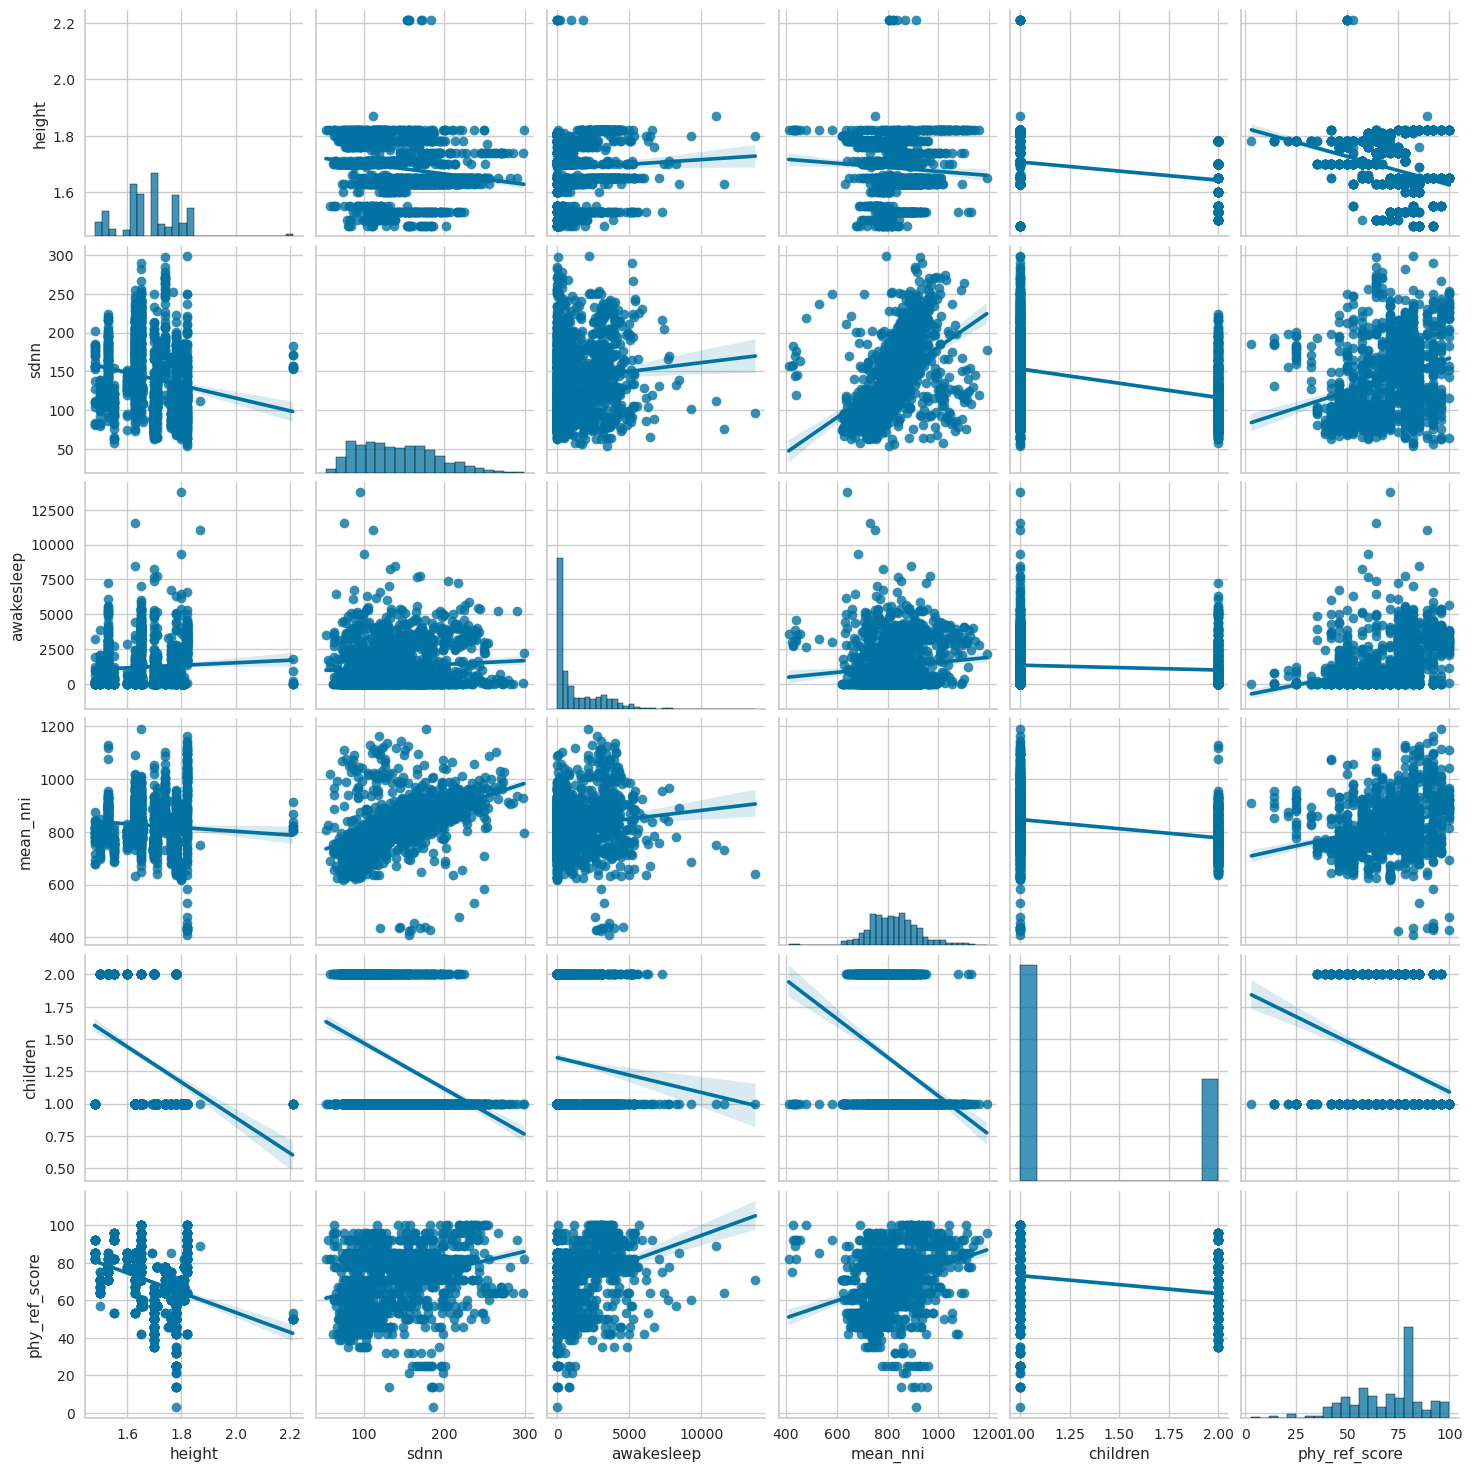

In [10]:
plt.figure(figsize=(14,8))
sns.pairplot(df_physical[['height', 'sdnn', 'awakesleep', 'mean_nni', 'children', 'phy_ref_score']], kind="reg")

<Axes: >

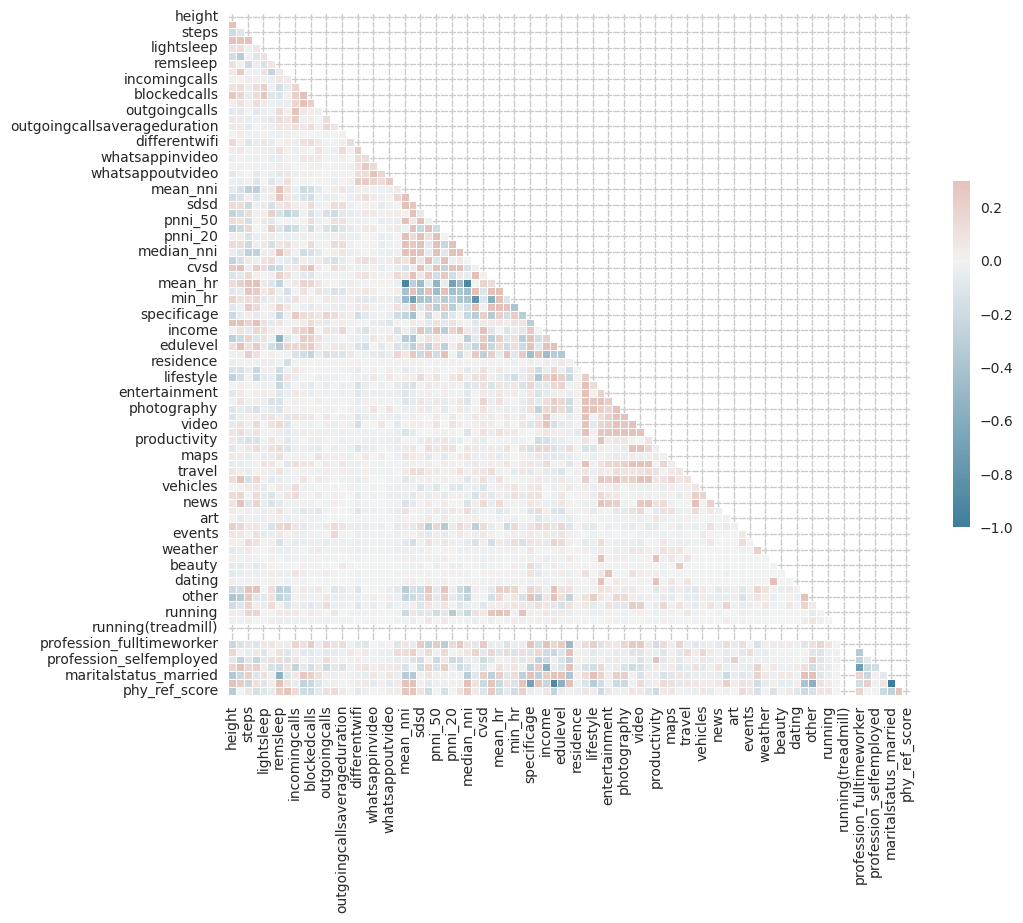

In [11]:
corr = df_physical.corr(method='pearson', numeric_only=True)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})